In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.io import wavfile
from scipy import signal
import IPython.display as ipd

In [2]:
sr, data = wavfile.read('f04.wav') 
if data.ndim > 1: # Mono conversion if stereo
    data = data.mean(axis=1)
data = data.astype(np.float32)

In [3]:
print("Original Audio:")
ipd.display(ipd.Audio(data, rate=sr))

Original Audio:


In [4]:
print('Sample Rate: ',sr)
print('Data: ',data)

Sample Rate:  16000
Data:  [ 19816.  30341.  27254. ...  -3029. -17556. -21767.]


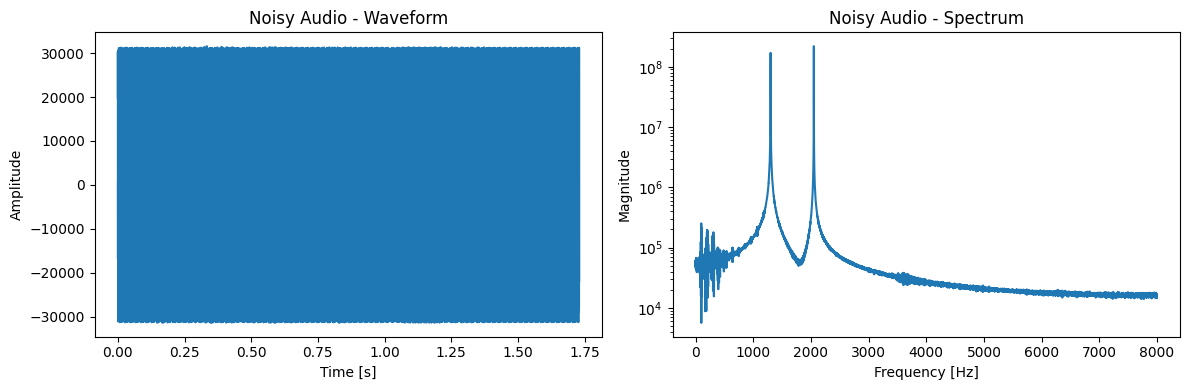

In [5]:
def plot_wave_and_spectrum(signal_data, sr, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    t = np.arange(len(signal_data)) / sr
    ax[0].plot(t, signal_data)
    ax[0].set_title(f"{title} - Waveform")
    ax[0].set_xlabel("Time [s]")
    ax[0].set_ylabel("Amplitude")

    freqs = np.fft.rfftfreq(len(signal_data), 1/sr)
    spectrum = np.abs(np.fft.rfft(signal_data))
    ax[1].semilogy(freqs, spectrum)
    ax[1].set_title(f"{title} - Spectrum")
    ax[1].set_xlabel("Frequency [Hz]")
    ax[1].set_ylabel("Magnitude")
    plt.tight_layout()
    plt.show()

plot_wave_and_spectrum(data, sr, "Noisy Audio")


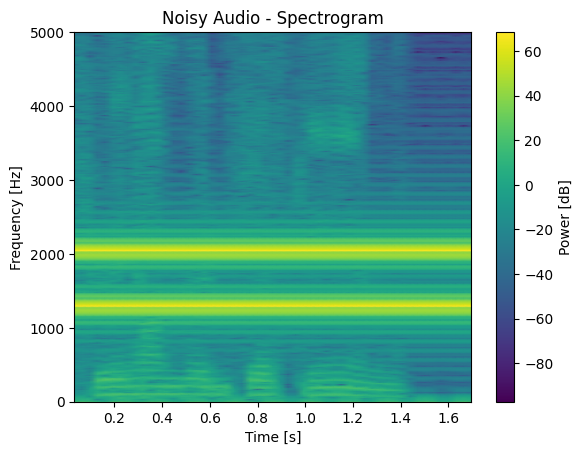

In [6]:
def plot_spectrogram(data, sr, title):
    f, t, Sxx = signal.spectrogram(data, sr, nperseg=1024, noverlap=512)
    plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud')
    plt.ylim(0, 5000)  # focus on speech + buzz range
    plt.colorbar(label='Power [dB]')
    plt.title(f'{title} - Spectrogram')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.show()
plot_spectrogram(data, sr,'Noisy Audio')

In [7]:
def apply_notches(sig_data, sr, f0, harmonics=5, Q=35):
    nyq = sr / 2
    out = sig_data
    for n in range(1, harmonics+1):
        fn = f0 * n
        if fn < nyq:
            b, a = signal.iirnotch(fn / nyq, Q)
            out = signal.filtfilt(b, a, out)
    return out

In [8]:
# Find multiple buzz peaks
freqs = np.fft.rfftfreq(len(data), 1/sr)
fft_magnitude = np.abs(np.fft.rfft(data))
# Threshold for strong narrow peaks
threshold = np.max(fft_magnitude) * 0.2 
buzz_peaks = freqs[(fft_magnitude > threshold) & (freqs > 20) & (freqs < 2500)]

# Round & deduplicate close peaks
buzz_peaks = np.unique(np.round(buzz_peaks, 1))
print("Detected buzz candidates:", buzz_peaks)

Detected buzz candidates: [1299.7 1300.2 1300.8 2050.1]


In [9]:
# Apply notches to all candidates + harmonics
clean = data
for f0 in buzz_peaks:
    clean = apply_notches(clean, sr, f0, harmonics=5, Q=40)

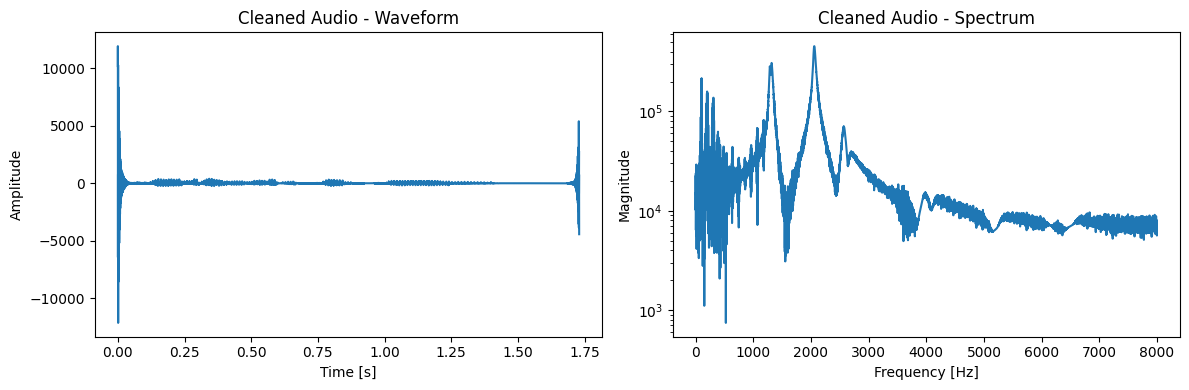

In [10]:
plot_wave_and_spectrum(clean, sr, "Cleaned Audio")

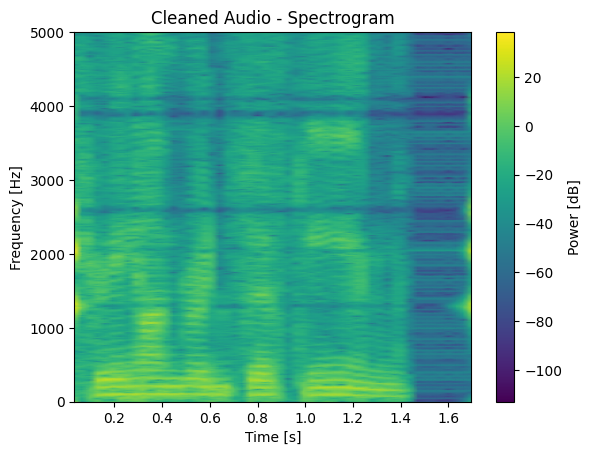

In [11]:
plot_spectrogram(clean, sr,'Cleaned Audio')

In [12]:
print("Filtered Audio:")
ipd.display(ipd.Audio(clean, rate=sr))

Filtered Audio:
